# Bird or Forest?

In [1]:
from fastai.data.all import *
from fastai.vision.all import *
from fastcore.all import *

c:\Users\micro\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Image Search

In [130]:
from duckduckgo_search import DDGS

def search_images(search_term, max_images = 10):
    return L(DDGS().images(search_term, max_results = max_images)).itemgot('image')

### Image Search Response

In [131]:
DDGS().images('bird photos')

[{'title': 'Green Bird · Free Stock Photo',
  'image': 'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg',
  'thumbnail': 'https://tse3.mm.bing.net/th?id=OIP.Ct8gRWSHnCcLr7ozTKmePAHaIp&pid=Api',
  'url': 'https://www.pexels.com/photo/green-bird-1661179/',
  'height': 2625,
  'width': 2250,
  'source': 'Bing'},
 {'title': '507 Colorful Bird Pictures · Pexels · Free Stock Photos',
  'image': 'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg',
  'thumbnail': 'https://tse3.mm.bing.net/th?id=OIP.3hTkhdPZ8PRL3R6saGGNAgHaE7&pid=Api',
  'url': 'https://www.pexels.com/search/bird/',
  'height': 1333,
  'width': 2000,
  'source': 'Bing'},
 {'title': 'Birds Images · Pexels · Free Stock Photos',
  'image': 'https://images.pexels.com/photos/97533/pexels-photo-97533.jpeg?cs=srgb&dl=animal-avian-bird-97533.jpg&fm=jpg',
  'thumbnail': 'https://tse2.mm.bing.net/th?id=OIP.e7i7kpiI3SU5

In [132]:
urls = search_images('bird photos', 10)
urls[0]

'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg'

c:\Users\micro\AppData\Local\Programs\Python\Python311\Lib\site-packages\curl_cffi\aio.py:204: UserWarning: Curlm alread closed! quitting from process_data
  warnings.warn("Curlm alread closed! quitting from process_data")


## Image Download

c:\Users\micro\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


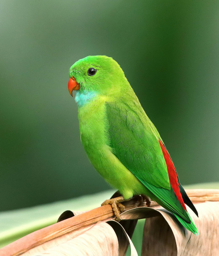

In [4]:
from fastai.vision.all import Image
from fastdownload import download_url

destination = 'images/bird.jpg'
download_url(urls[0], destination)

image = Image.open(destination)
image.to_thumb(256, 256)

### Forest Test

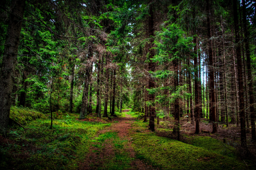

c:\Users\micro\AppData\Local\Programs\Python\Python311\Lib\site-packages\curl_cffi\aio.py:204: UserWarning: Curlm alread closed! quitting from process_data
  warnings.warn("Curlm alread closed! quitting from process_data")


In [5]:
download_url(search_images('forest photo', max_images = 1)[0], 'images/forest.jpg')
Image.open('images/forest.jpg').to_thumb(256, 256)

## Download Data Sets

In [3]:
from pathlib import Path
data_set_path = Path('bird_or_not')

In [4]:
from fastai.vision.utils import download_images, resize_images
from time import sleep # Be nice to the DDG servers.

searches = ['bird', 'forest']

for search in searches:
    destination = data_set_path/search
    destination.mkdir(exist_ok = True, parents = True)
    download_images(dest = destination, urls = search_images(f'{search} photo', max_images = 25))
    sleep(5)
    # Search for different lighting conditions.
    download_images(dest = destination, urls = search_images(f'{search} sun photo', max_images = 25))
    sleep(5)
    download_images(dest = destination, urls = search_images(f'{search} shade photo', max_images = 25))
    resize_images(path = destination, max_size = 400, dest = destination)

c:\Users\micro\AppData\Local\Programs\Python\Python311\Lib\site-packages\curl_cffi\aio.py:204: UserWarning: Curlm alread closed! quitting from process_data
  warnings.warn("Curlm alread closed! quitting from process_data")


## Verify Images

In [134]:
from fastai.vision.utils import get_image_files, verify_images

failed_images = verify_images(get_image_files(data_set_path))
failed_images.map(Path.unlink)
len(failed_images)

0

## Construct Training and Validation Sets

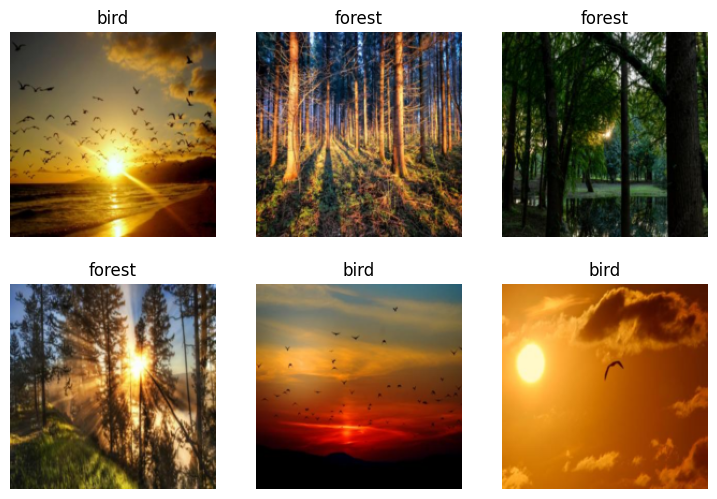

In [4]:
data_loaders = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = [Resize(192, method = 'squish')],
).dataloaders(data_set_path, bs = 32)

data_loaders.show_batch(max_n = 6)

## Train Model

In [125]:
import torch

print(f'GPU Available: {torch.cuda.is_available()}')
print(f'GPU Device: {torch.cuda.get_device_name(0)}')
print(f'CUDA Version: {torch.version.cuda}')

# Shouldn't be necessary, just for reference:
# torch.set_default_device('cuda')
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

GPU Available: True
GPU Device: NVIDIA GeForce RTX 3090
CUDA Version: 11.8


In [5]:
from fastai.vision.learner import vision_learner, error_rate
from fastai.vision.models import resnet18

model = vision_learner(data_loaders, arch = resnet18, metrics = error_rate)
model.fine_tune(3)

In [28]:
# Sanity checks
print(model.dls.device)

x, y = data_loaders.one_batch()
print(x.device, y.device)

print(next(model.model.parameters()).device)

cuda:0
cuda:0 cuda:0
cuda:0


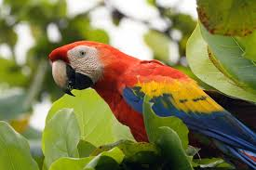

In [22]:
test_image = PILImage.create('test_images/bird.jpg')
test_image.to_thumb(256, 256)

In [24]:
category, _, probability = model.predict(test_image)
print(f"Category: {category}.")
print(f"Probabilities: {probability}")

Category: bird.
Probabilities: tensor([9.9999e-01, 5.3161e-06])


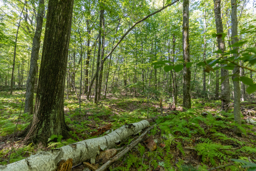

In [25]:
test_image = PILImage.create('test_images/forest.jpg')
test_image.to_thumb(256, 256)

In [26]:
category, _, probability = model.predict(test_image)
print(f"Category: {category}.")
print(f"Probabilities: {probability}")

Category: forest.
Probabilities: tensor([5.5726e-04, 9.9944e-01])
